In [4]:
import random
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sk
import pickle
import mne
import tqdm
from tqdm import trange
import os

DEVICE='cuda'
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim

from torch import nn

In [6]:
def extract_data(sub_range,verbose=False,feature_func=None,**kwargs):
    first=sub_range[0]
    last=sub_range[-1]

    for sub in trange(first,last+1): 
        #read data
        if sub <=9:
            path=f'ds005540\derivatives\sub-0{sub}\ses-vid\eeg\sub-0{sub}_ses-vid_task-emotion_reorder.npy'
        else:
            path=f'ds005540\derivatives\sub-{sub}\ses-vid\eeg\sub-{sub}_ses-vid_task-emotion_reorder.npy'
        datatemp=np.load(path,allow_pickle=True)
        datatemp=np.permute_dims(datatemp,[1,0,2])

        #if we want to convert features
        if not feature_func==None:
            datatemp=feature_func(datatemp,info=info)

        #cat data along new dimension
        datatemp=torch.tensor(datatemp).unsqueeze(0)
        if sub==first:
            data=datatemp
        else:
            data=torch.cat([data,datatemp],axis=0)

        if verbose:
            print(f'subject {sub} data extracted, vector size: {data.shape}')
    return data

def shuffle_and_split_data(X,y):
    """
    Helper function to shuffle and split data

    Args:
        X: torch.tensor
        Input data
        y: torch.tensor
        Corresponding target variables
        seed: int
        Set seed for reproducibility

    Returns:
        X_test: torch.tensor
        Test data [20% of X]
        y_test: torch.tensor
        Labels corresponding to above mentioned test data
        X_train: torch.tensor
        Train data [80% of X]
        y_train: torch.tensor
        Labels corresponding to above mentioned train data
    """
    
    N=X.size(0)
    shuffled_indices=torch.randperm(N) #get shuffled indices
    X=X[shuffled_indices]
    y=y[shuffled_indices]

    # split by 20% into train-test set
    test_size=int(0.2*N)
    X_train=X[test_size:]
    y_train=y[test_size:]
    X_test=X[:test_size]
    y_test=y[:test_size]

    return X_test,y_test,X_train,y_train

#create labels
#sad-dis-fear-neu-joy-ten-ins correspond to 0-6 respectively, each sample has 21 trials, for (7 emotions x 3 trials)
labels=np.array([])
for i in range(0,7):
    for n in range(0,3):
        labels=np.concatenate([labels,np.array([i])],axis=0)
labels=torch.tensor(labels)

<>:8: SyntaxWarning: invalid escape sequence '\d'
<>:8: SyntaxWarning: invalid escape sequence '\s'
<>:10: SyntaxWarning: invalid escape sequence '\d'
<>:10: SyntaxWarning: invalid escape sequence '\s'
<>:8: SyntaxWarning: invalid escape sequence '\d'
<>:8: SyntaxWarning: invalid escape sequence '\s'
<>:10: SyntaxWarning: invalid escape sequence '\d'
<>:10: SyntaxWarning: invalid escape sequence '\s'
C:\Users\malco\AppData\Local\Temp\ipykernel_20512\2464512495.py:8: SyntaxWarning: invalid escape sequence '\d'
  path=f'ds005540\derivatives\sub-0{sub}\ses-vid\eeg\sub-0{sub}_ses-vid_task-emotion_reorder.npy'
C:\Users\malco\AppData\Local\Temp\ipykernel_20512\2464512495.py:8: SyntaxWarning: invalid escape sequence '\s'
  path=f'ds005540\derivatives\sub-0{sub}\ses-vid\eeg\sub-0{sub}_ses-vid_task-emotion_reorder.npy'
C:\Users\malco\AppData\Local\Temp\ipykernel_20512\2464512495.py:10: SyntaxWarning: invalid escape sequence '\d'
  path=f'ds005540\derivatives\sub-{sub}\ses-vid\eeg\sub-{sub}_ses-

In [7]:
data=extract_data([1,20])

100%|██████████| 20/20 [00:03<00:00,  5.41it/s]


In [8]:
def process_data(data):
    '''further process into trials (1 second trials, 200 points)'''
    for trial in tqdm.tqdm(range(int(data.size(3)/200))):
        datatrial=data[:,:,:,trial*200:(trial+1)*200]
        datatrial=torch.unsqueeze(datatrial,2)
        if trial==0:
            newdata=datatrial
        else:
            newdata=torch.concatenate((newdata,datatrial),2)
    return newdata

In [9]:
data=process_data(data)
data.shape #subject,label,trials,electrodes,timepoints

100%|██████████| 30/30 [00:03<00:00,  8.57it/s]


torch.Size([20, 21, 30, 64, 200])

In [10]:
for label in tqdm.tqdm(range(21)): #combine labels and trials
    temp=data[:,label,:,:,:]
    if label==0:
        X=temp
        y=labels[label]*torch.ones(30,1)
    else:
        X=torch.concatenate((X,temp),dim=1)
        y=torch.concatenate((y,labels[label]*torch.ones(30,1)),dim=0)

#combine subjects
for subject in tqdm.tqdm(range(X.size(0))):
    temp=X[subject,:,:,:]
    if subject==0:
        X_full=temp
        y_full=y
    else:
        X_full=torch.concatenate((X_full,temp),dim=0)
        y_full=torch.concatenate((y_full,y),dim=0)
        
#split data
X_test,y_test,X_train,y_train=shuffle_and_split_data(X_full.unsqueeze(1),y_full.squeeze())

print(X_test.shape,y_test.shape,X_train.shape,y_train.shape)

100%|██████████| 20/20 [00:02<00:00,  9.25it/s]

torch.Size([2520, 1, 64, 200]) torch.Size([2520]) torch.Size([10080, 1, 64, 200]) torch.Size([10080])


In [11]:
#now the model
class Net(nn.Module):
    def __init__(self,dropout):
        super(Net,self).__init__()
        self.conv1=nn.Conv2d(1,32,7,stride=1,padding=3)
        self.conv2=nn.Conv2d(32,16,7,stride=1,padding=3)
        self.conv3=nn.Conv2d(16,8,5,stride=1,padding=2)
        self.conv4=nn.Conv2d(8,16,5,stride=1,padding=2)
        self.conv5=nn.Conv2d(16,4,3,stride=1,padding=1)
        self.pool1=nn.MaxPool2d(2)
        self.pool2=nn.MaxPool2d(4)
        self.fc1=nn.Linear(800,7)
        self.dropout1=nn.Dropout2d(dropout)
        self.batchnorm1=nn.BatchNorm2d(32)
        self.batchnorm2=nn.BatchNorm2d(16)
        self.batchnorm3=nn.BatchNorm2d(8)
        self.batchnorm4=nn.BatchNorm2d(4)

    def forward(self,x):
        x=self.conv1(x)
        x=self.batchnorm1(x)
        x=self.dropout1(x)
        x=nn.functional.relu(x)

        x=self.conv2(x)
        x=self.batchnorm2(x)
        x=self.dropout1(x)
        x=nn.functional.relu(x)
        x=self.pool1(x)

        x=self.conv3(x)
        x=self.batchnorm3(x)
        x=self.dropout1(x)
        x=nn.functional.relu(x)

        x=self.conv4(x)
        x=self.batchnorm2(x)
        x=self.dropout1(x)
        x=nn.functional.relu(x)

        x=self.conv5(x)
        x=self.batchnorm4(x)
        x=self.dropout1(x)
        x=nn.functional.relu(x)
        x=self.pool2(x)

        x=torch.flatten(x,1)
        x=self.fc1(x)
        return x
    


def train_test(net,epochs,train_loader,test_loader,device):
    criterion=nn.CrossEntropyLoss()
    optimizer=optim.Adam(net.parameters(),lr=1e-2)
    train_acc=[]
    train_loss=[]
    test_acc=[]
    test_loss=[]
    net.to(device)
    for epoch in tqdm.tqdm(range(epochs)):
        net.train()
        running_loss=0.0
        correct,total=0,0
        for i,data in enumerate(train_loader,start=0):
            inputs,labels=data
            inputs=inputs.to(device).float()
            labels=labels.to(device).long()
            
            #train
            optimizer.zero_grad()
            outputs=net.forward(inputs)
            loss=criterion(outputs,labels)
            loss.backward()
            optimizer.step()

            running_loss+=loss.item()
            #training accuracy
            _,predicted=torch.max(outputs,1)
            total+=labels.size(0)
            correct+=(predicted==labels).sum()
        train_loss.append(running_loss/len(train_loader))
        train_acc.append(correct/total)
        print(f"epoch {epoch} --> TRAIN loss: {running_loss/len(train_loader):.5f}, TRAIN accuracy: {correct/total:.2f}")

        #eval on test
        net.eval()
        running_loss=0.0
        correct,total=0,0
        for inputs,labels in test_loader:
            inputs,labels=inputs.to(device).float(),labels.to(device).long()
            outputs=net.forward(inputs)
            loss=criterion(outputs,labels)
            running_loss+=loss.item()

            #test acc
            _,predicted=torch.max(outputs,1)
            total+=labels.size(0)
            correct+=(predicted==labels).sum()
        test_loss.append(running_loss/len(test_loader))
        test_acc.append(correct/total)
        print(f"epoch {epoch} --> TEST loss: {running_loss/len(train_loader):.2f}, TEST accuracy: {correct/total:.2f}")

    return train_loss,train_acc,test_loss,test_acc


batch_size=300
test_data = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_data, batch_size=batch_size,
                         shuffle=False,num_workers=1
                         )

train_data = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_data,
                          batch_size=batch_size,
                          drop_last=False,
                          shuffle=True,num_workers=1
                          )

In [12]:
net=Net(dropout=0.3)
train_loss,train_acc,test_loss,test_acc=train_test(net,250,train_loader=train_loader,test_loader=test_loader,device=DEVICE)

  0%|          | 0/250 [00:00<?, ?it/s]

epoch 0 --> TRAIN loss: 2.10424, TRAIN accuracy: 0.14


  0%|          | 1/250 [00:19<1:20:42, 19.45s/it]

epoch 0 --> TEST loss: 0.52, TEST accuracy: 0.14
epoch 1 --> TRAIN loss: 1.94633, TRAIN accuracy: 0.14


  1%|          | 2/250 [00:35<1:11:53, 17.39s/it]

epoch 1 --> TEST loss: 0.52, TEST accuracy: 0.13
epoch 2 --> TRAIN loss: 1.94683, TRAIN accuracy: 0.14


  1%|          | 3/250 [00:51<1:08:52, 16.73s/it]

epoch 2 --> TEST loss: 0.52, TEST accuracy: 0.13
epoch 3 --> TRAIN loss: 1.94631, TRAIN accuracy: 0.14


  2%|▏         | 4/250 [01:07<1:07:46, 16.53s/it]

epoch 3 --> TEST loss: 0.52, TEST accuracy: 0.13
epoch 4 --> TRAIN loss: 1.94622, TRAIN accuracy: 0.14


  2%|▏         | 5/250 [01:23<1:06:41, 16.33s/it]

epoch 4 --> TEST loss: 0.52, TEST accuracy: 0.13
epoch 5 --> TRAIN loss: 1.94610, TRAIN accuracy: 0.14


  2%|▏         | 6/250 [01:39<1:05:56, 16.22s/it]

epoch 5 --> TEST loss: 0.52, TEST accuracy: 0.13
epoch 6 --> TRAIN loss: 1.94615, TRAIN accuracy: 0.15


  3%|▎         | 7/250 [01:55<1:05:23, 16.15s/it]

epoch 6 --> TEST loss: 0.52, TEST accuracy: 0.13
epoch 7 --> TRAIN loss: 1.94622, TRAIN accuracy: 0.14


  3%|▎         | 8/250 [02:11<1:04:41, 16.04s/it]

epoch 7 --> TEST loss: 0.52, TEST accuracy: 0.13
epoch 8 --> TRAIN loss: 1.94604, TRAIN accuracy: 0.15


  4%|▎         | 9/250 [02:27<1:04:44, 16.12s/it]

epoch 8 --> TEST loss: 0.52, TEST accuracy: 0.13
epoch 9 --> TRAIN loss: 1.94607, TRAIN accuracy: 0.14


  4%|▍         | 10/250 [02:44<1:05:14, 16.31s/it]

epoch 9 --> TEST loss: 0.52, TEST accuracy: 0.13
epoch 10 --> TRAIN loss: 1.94608, TRAIN accuracy: 0.14


  4%|▍         | 11/250 [03:01<1:06:31, 16.70s/it]

epoch 10 --> TEST loss: 0.52, TEST accuracy: 0.13
epoch 11 --> TRAIN loss: 1.94621, TRAIN accuracy: 0.14


  5%|▍         | 12/250 [03:19<1:07:32, 17.03s/it]

epoch 11 --> TEST loss: 0.52, TEST accuracy: 0.13
epoch 12 --> TRAIN loss: 1.94673, TRAIN accuracy: 0.14


  5%|▌         | 13/250 [03:37<1:08:19, 17.30s/it]

epoch 12 --> TEST loss: 0.52, TEST accuracy: 0.13
epoch 13 --> TRAIN loss: 1.94609, TRAIN accuracy: 0.14


  6%|▌         | 14/250 [03:54<1:07:37, 17.19s/it]

epoch 13 --> TEST loss: 0.52, TEST accuracy: 0.13
epoch 14 --> TRAIN loss: 1.94617, TRAIN accuracy: 0.14


  6%|▌         | 15/250 [04:10<1:06:22, 16.95s/it]

epoch 14 --> TEST loss: 0.52, TEST accuracy: 0.13
epoch 15 --> TRAIN loss: 1.94609, TRAIN accuracy: 0.15


  6%|▋         | 16/250 [04:27<1:05:37, 16.83s/it]

epoch 15 --> TEST loss: 0.52, TEST accuracy: 0.13
epoch 16 --> TRAIN loss: 1.94608, TRAIN accuracy: 0.14


  7%|▋         | 17/250 [04:43<1:04:38, 16.65s/it]

epoch 16 --> TEST loss: 0.52, TEST accuracy: 0.13
epoch 17 --> TRAIN loss: 1.94614, TRAIN accuracy: 0.14


  7%|▋         | 18/250 [05:00<1:04:27, 16.67s/it]

epoch 17 --> TEST loss: 0.52, TEST accuracy: 0.13
epoch 18 --> TRAIN loss: 1.94605, TRAIN accuracy: 0.15


  8%|▊         | 19/250 [05:16<1:03:38, 16.53s/it]

epoch 18 --> TEST loss: 0.52, TEST accuracy: 0.13
epoch 19 --> TRAIN loss: 1.94623, TRAIN accuracy: 0.14


  8%|▊         | 20/250 [05:32<1:02:42, 16.36s/it]

epoch 19 --> TEST loss: 0.52, TEST accuracy: 0.13
epoch 20 --> TRAIN loss: 1.94642, TRAIN accuracy: 0.14


  8%|▊         | 21/250 [05:48<1:01:54, 16.22s/it]

epoch 20 --> TEST loss: 0.52, TEST accuracy: 0.14
epoch 21 --> TRAIN loss: 1.94612, TRAIN accuracy: 0.14


  9%|▉         | 22/250 [06:04<1:01:47, 16.26s/it]

epoch 21 --> TEST loss: 0.52, TEST accuracy: 0.13
epoch 22 --> TRAIN loss: 1.94650, TRAIN accuracy: 0.14


  9%|▉         | 23/250 [06:21<1:01:41, 16.31s/it]

epoch 22 --> TEST loss: 0.52, TEST accuracy: 0.13
epoch 23 --> TRAIN loss: 1.94617, TRAIN accuracy: 0.15


 10%|▉         | 24/250 [06:37<1:01:14, 16.26s/it]

epoch 23 --> TEST loss: 0.52, TEST accuracy: 0.13
epoch 24 --> TRAIN loss: 1.94610, TRAIN accuracy: 0.14


 10%|█         | 25/250 [06:53<1:00:56, 16.25s/it]

epoch 24 --> TEST loss: 0.52, TEST accuracy: 0.13
epoch 25 --> TRAIN loss: 1.94611, TRAIN accuracy: 0.14


 10%|█         | 26/250 [07:09<1:00:20, 16.16s/it]

epoch 25 --> TEST loss: 0.52, TEST accuracy: 0.13
epoch 26 --> TRAIN loss: 1.94625, TRAIN accuracy: 0.14


 11%|█         | 27/250 [07:25<59:41, 16.06s/it]  

epoch 26 --> TEST loss: 0.52, TEST accuracy: 0.13
epoch 27 --> TRAIN loss: 1.94609, TRAIN accuracy: 0.14


 11%|█         | 28/250 [07:41<59:17, 16.03s/it]

epoch 27 --> TEST loss: 0.52, TEST accuracy: 0.13
epoch 28 --> TRAIN loss: 1.94601, TRAIN accuracy: 0.14


 12%|█▏        | 29/250 [07:57<59:05, 16.04s/it]

epoch 28 --> TEST loss: 0.52, TEST accuracy: 0.13
epoch 29 --> TRAIN loss: 1.94608, TRAIN accuracy: 0.15


 12%|█▏        | 30/250 [08:13<58:55, 16.07s/it]

epoch 29 --> TEST loss: 0.52, TEST accuracy: 0.13
epoch 30 --> TRAIN loss: 1.94629, TRAIN accuracy: 0.14


 12%|█▏        | 31/250 [08:29<58:51, 16.12s/it]

epoch 30 --> TEST loss: 0.52, TEST accuracy: 0.13
epoch 31 --> TRAIN loss: 1.94613, TRAIN accuracy: 0.14


 13%|█▎        | 32/250 [08:46<58:53, 16.21s/it]

epoch 31 --> TEST loss: 0.52, TEST accuracy: 0.13
epoch 32 --> TRAIN loss: 1.94626, TRAIN accuracy: 0.14


 13%|█▎        | 33/250 [09:02<58:35, 16.20s/it]

epoch 32 --> TEST loss: 0.52, TEST accuracy: 0.13
epoch 33 --> TRAIN loss: 1.94614, TRAIN accuracy: 0.14


 14%|█▎        | 34/250 [09:18<57:51, 16.07s/it]

epoch 33 --> TEST loss: 0.52, TEST accuracy: 0.13
epoch 34 --> TRAIN loss: 1.94622, TRAIN accuracy: 0.14


 14%|█▍        | 35/250 [09:34<57:46, 16.12s/it]

epoch 34 --> TEST loss: 0.52, TEST accuracy: 0.13
epoch 35 --> TRAIN loss: 1.94637, TRAIN accuracy: 0.14


 14%|█▍        | 36/250 [09:50<57:35, 16.15s/it]

epoch 35 --> TEST loss: 0.52, TEST accuracy: 0.13
epoch 36 --> TRAIN loss: 1.94639, TRAIN accuracy: 0.14


 15%|█▍        | 37/250 [10:07<57:34, 16.22s/it]

epoch 36 --> TEST loss: 0.52, TEST accuracy: 0.14
epoch 37 --> TRAIN loss: 1.94640, TRAIN accuracy: 0.14


 15%|█▌        | 38/250 [10:23<57:00, 16.14s/it]

epoch 37 --> TEST loss: 0.52, TEST accuracy: 0.13
epoch 38 --> TRAIN loss: 1.94609, TRAIN accuracy: 0.15


 16%|█▌        | 39/250 [10:39<57:05, 16.24s/it]

epoch 38 --> TEST loss: 0.52, TEST accuracy: 0.13
epoch 39 --> TRAIN loss: 1.94609, TRAIN accuracy: 0.14


 16%|█▌        | 40/250 [10:55<56:44, 16.21s/it]

epoch 39 --> TEST loss: 0.52, TEST accuracy: 0.13
epoch 40 --> TRAIN loss: 1.94627, TRAIN accuracy: 0.15


 16%|█▋        | 41/250 [11:11<56:22, 16.18s/it]

epoch 40 --> TEST loss: 0.52, TEST accuracy: 0.13
epoch 41 --> TRAIN loss: 1.94622, TRAIN accuracy: 0.14


 17%|█▋        | 42/250 [11:27<55:30, 16.01s/it]

epoch 41 --> TEST loss: 0.52, TEST accuracy: 0.13
epoch 42 --> TRAIN loss: 1.94633, TRAIN accuracy: 0.14


 17%|█▋        | 43/250 [11:43<55:07, 15.98s/it]

epoch 42 --> TEST loss: 0.52, TEST accuracy: 0.13
epoch 43 --> TRAIN loss: 1.94630, TRAIN accuracy: 0.14


 18%|█▊        | 44/250 [11:59<55:14, 16.09s/it]

epoch 43 --> TEST loss: 0.52, TEST accuracy: 0.13
epoch 44 --> TRAIN loss: 1.94617, TRAIN accuracy: 0.14


 18%|█▊        | 45/250 [12:15<54:47, 16.04s/it]

epoch 44 --> TEST loss: 0.52, TEST accuracy: 0.13
epoch 45 --> TRAIN loss: 1.94616, TRAIN accuracy: 0.14


 18%|█▊        | 46/250 [12:31<54:15, 15.96s/it]

epoch 45 --> TEST loss: 0.52, TEST accuracy: 0.13
epoch 46 --> TRAIN loss: 1.94615, TRAIN accuracy: 0.15


 19%|█▉        | 47/250 [12:47<53:58, 15.95s/it]

epoch 46 --> TEST loss: 0.52, TEST accuracy: 0.13
epoch 47 --> TRAIN loss: 1.94622, TRAIN accuracy: 0.14


 19%|█▉        | 48/250 [13:03<54:03, 16.06s/it]

epoch 47 --> TEST loss: 0.52, TEST accuracy: 0.13
epoch 48 --> TRAIN loss: 1.94637, TRAIN accuracy: 0.13


 20%|█▉        | 49/250 [13:19<53:43, 16.04s/it]

epoch 48 --> TEST loss: 0.52, TEST accuracy: 0.13
epoch 49 --> TRAIN loss: 1.94627, TRAIN accuracy: 0.14


 20%|██        | 50/250 [13:35<53:26, 16.03s/it]

epoch 49 --> TEST loss: 0.52, TEST accuracy: 0.14
epoch 50 --> TRAIN loss: 1.94625, TRAIN accuracy: 0.14


 20%|██        | 51/250 [13:51<53:06, 16.01s/it]

epoch 50 --> TEST loss: 0.52, TEST accuracy: 0.13
epoch 51 --> TRAIN loss: 1.94617, TRAIN accuracy: 0.14


 21%|██        | 52/250 [14:07<52:37, 15.95s/it]

epoch 51 --> TEST loss: 0.52, TEST accuracy: 0.13
epoch 52 --> TRAIN loss: 1.94634, TRAIN accuracy: 0.15


 21%|██        | 53/250 [14:23<52:14, 15.91s/it]

epoch 52 --> TEST loss: 0.52, TEST accuracy: 0.13
epoch 53 --> TRAIN loss: 1.94610, TRAIN accuracy: 0.15


 22%|██▏       | 54/250 [14:39<52:02, 15.93s/it]

epoch 53 --> TEST loss: 0.52, TEST accuracy: 0.13
epoch 54 --> TRAIN loss: 1.94627, TRAIN accuracy: 0.14


 22%|██▏       | 55/250 [14:55<52:07, 16.04s/it]

epoch 54 --> TEST loss: 0.52, TEST accuracy: 0.13
epoch 55 --> TRAIN loss: 1.94619, TRAIN accuracy: 0.15


 22%|██▏       | 56/250 [15:11<51:44, 16.00s/it]

epoch 55 --> TEST loss: 0.52, TEST accuracy: 0.13
epoch 56 --> TRAIN loss: 1.94629, TRAIN accuracy: 0.14


 23%|██▎       | 57/250 [15:27<51:23, 15.98s/it]

epoch 56 --> TEST loss: 0.52, TEST accuracy: 0.13
epoch 57 --> TRAIN loss: 1.94628, TRAIN accuracy: 0.14


 23%|██▎       | 58/250 [15:43<51:00, 15.94s/it]

epoch 57 --> TEST loss: 0.52, TEST accuracy: 0.13
epoch 58 --> TRAIN loss: 1.94637, TRAIN accuracy: 0.15


 24%|██▎       | 59/250 [15:59<50:48, 15.96s/it]

epoch 58 --> TEST loss: 0.52, TEST accuracy: 0.13
epoch 59 --> TRAIN loss: 1.94623, TRAIN accuracy: 0.13


 24%|██▍       | 60/250 [16:15<50:48, 16.04s/it]

epoch 59 --> TEST loss: 0.52, TEST accuracy: 0.13
epoch 60 --> TRAIN loss: 1.94618, TRAIN accuracy: 0.15


 24%|██▍       | 61/250 [16:31<50:28, 16.02s/it]

epoch 60 --> TEST loss: 0.52, TEST accuracy: 0.13
epoch 61 --> TRAIN loss: 1.94638, TRAIN accuracy: 0.14


 25%|██▍       | 62/250 [16:47<50:11, 16.02s/it]

epoch 61 --> TEST loss: 0.52, TEST accuracy: 0.13
epoch 62 --> TRAIN loss: 1.94616, TRAIN accuracy: 0.15


 25%|██▌       | 63/250 [17:03<49:49, 15.99s/it]

epoch 62 --> TEST loss: 0.52, TEST accuracy: 0.13
epoch 63 --> TRAIN loss: 1.94620, TRAIN accuracy: 0.14


 26%|██▌       | 64/250 [17:19<49:24, 15.94s/it]

epoch 63 --> TEST loss: 0.52, TEST accuracy: 0.13
epoch 64 --> TRAIN loss: 1.94618, TRAIN accuracy: 0.14


 26%|██▌       | 65/250 [17:35<49:09, 15.94s/it]

epoch 64 --> TEST loss: 0.52, TEST accuracy: 0.13
epoch 65 --> TRAIN loss: 1.94603, TRAIN accuracy: 0.15


 26%|██▋       | 66/250 [17:50<48:45, 15.90s/it]

epoch 65 --> TEST loss: 0.52, TEST accuracy: 0.13
epoch 66 --> TRAIN loss: 1.94618, TRAIN accuracy: 0.14


 27%|██▋       | 67/250 [18:06<48:17, 15.83s/it]

epoch 66 --> TEST loss: 0.52, TEST accuracy: 0.13
epoch 67 --> TRAIN loss: 1.94615, TRAIN accuracy: 0.14


 27%|██▋       | 68/250 [18:22<47:45, 15.74s/it]

epoch 67 --> TEST loss: 0.52, TEST accuracy: 0.13
epoch 68 --> TRAIN loss: 1.94639, TRAIN accuracy: 0.14


 28%|██▊       | 69/250 [18:37<47:36, 15.78s/it]

epoch 68 --> TEST loss: 0.52, TEST accuracy: 0.13
epoch 69 --> TRAIN loss: 1.94621, TRAIN accuracy: 0.14


 28%|██▊       | 70/250 [18:53<47:27, 15.82s/it]

epoch 69 --> TEST loss: 0.52, TEST accuracy: 0.13
epoch 70 --> TRAIN loss: 1.94637, TRAIN accuracy: 0.15


 28%|██▊       | 71/250 [19:09<47:14, 15.83s/it]

epoch 70 --> TEST loss: 0.52, TEST accuracy: 0.13
epoch 71 --> TRAIN loss: 1.94608, TRAIN accuracy: 0.14


 29%|██▉       | 72/250 [19:25<47:18, 15.95s/it]

epoch 71 --> TEST loss: 0.52, TEST accuracy: 0.13
epoch 72 --> TRAIN loss: 1.94608, TRAIN accuracy: 0.14


 29%|██▉       | 73/250 [19:41<47:02, 15.95s/it]

epoch 72 --> TEST loss: 0.52, TEST accuracy: 0.13
epoch 73 --> TRAIN loss: 1.94630, TRAIN accuracy: 0.14


 30%|██▉       | 74/250 [19:57<46:47, 15.95s/it]

epoch 73 --> TEST loss: 0.52, TEST accuracy: 0.13
epoch 74 --> TRAIN loss: 1.94613, TRAIN accuracy: 0.14


 30%|███       | 75/250 [20:13<46:34, 15.97s/it]

epoch 74 --> TEST loss: 0.52, TEST accuracy: 0.13
epoch 75 --> TRAIN loss: 1.94625, TRAIN accuracy: 0.14


 30%|███       | 76/250 [20:29<46:23, 16.00s/it]

epoch 75 --> TEST loss: 0.52, TEST accuracy: 0.13
epoch 76 --> TRAIN loss: 1.94606, TRAIN accuracy: 0.14


 31%|███       | 77/250 [20:45<46:13, 16.03s/it]

epoch 76 --> TEST loss: 0.52, TEST accuracy: 0.13
epoch 77 --> TRAIN loss: 1.94613, TRAIN accuracy: 0.15


 31%|███       | 78/250 [21:02<46:20, 16.16s/it]

epoch 77 --> TEST loss: 0.52, TEST accuracy: 0.13
epoch 78 --> TRAIN loss: 1.94612, TRAIN accuracy: 0.15


 32%|███▏      | 79/250 [21:18<46:05, 16.17s/it]

epoch 78 --> TEST loss: 0.52, TEST accuracy: 0.13
epoch 79 --> TRAIN loss: 1.94608, TRAIN accuracy: 0.14


 32%|███▏      | 80/250 [21:34<45:42, 16.13s/it]

epoch 79 --> TEST loss: 0.52, TEST accuracy: 0.13
epoch 80 --> TRAIN loss: 1.94636, TRAIN accuracy: 0.15


 32%|███▏      | 81/250 [21:50<45:28, 16.15s/it]

epoch 80 --> TEST loss: 0.52, TEST accuracy: 0.13
epoch 81 --> TRAIN loss: 1.94607, TRAIN accuracy: 0.14


 33%|███▎      | 82/250 [22:07<45:29, 16.24s/it]

epoch 81 --> TEST loss: 0.52, TEST accuracy: 0.13
epoch 82 --> TRAIN loss: 1.94618, TRAIN accuracy: 0.15


 33%|███▎      | 83/250 [22:23<45:17, 16.27s/it]

epoch 82 --> TEST loss: 0.52, TEST accuracy: 0.13
epoch 83 --> TRAIN loss: 1.94625, TRAIN accuracy: 0.14


 34%|███▎      | 84/250 [22:40<45:23, 16.41s/it]

epoch 83 --> TEST loss: 0.52, TEST accuracy: 0.13
epoch 84 --> TRAIN loss: 1.94624, TRAIN accuracy: 0.14


 34%|███▍      | 85/250 [22:56<44:57, 16.35s/it]

epoch 84 --> TEST loss: 0.52, TEST accuracy: 0.13
epoch 85 --> TRAIN loss: 1.94638, TRAIN accuracy: 0.14


 34%|███▍      | 86/250 [23:12<44:23, 16.24s/it]

epoch 85 --> TEST loss: 0.52, TEST accuracy: 0.13
epoch 86 --> TRAIN loss: 1.94612, TRAIN accuracy: 0.15


 35%|███▍      | 87/250 [23:28<43:42, 16.09s/it]

epoch 86 --> TEST loss: 0.52, TEST accuracy: 0.13
epoch 87 --> TRAIN loss: 1.94623, TRAIN accuracy: 0.14


 35%|███▌      | 88/250 [23:43<43:02, 15.94s/it]

epoch 87 --> TEST loss: 0.52, TEST accuracy: 0.13
epoch 88 --> TRAIN loss: 1.94627, TRAIN accuracy: 0.14


 36%|███▌      | 89/250 [23:59<42:39, 15.90s/it]

epoch 88 --> TEST loss: 0.52, TEST accuracy: 0.14
epoch 89 --> TRAIN loss: 1.94609, TRAIN accuracy: 0.14


 36%|███▌      | 90/250 [24:15<42:20, 15.88s/it]

epoch 89 --> TEST loss: 0.52, TEST accuracy: 0.13
epoch 90 --> TRAIN loss: 1.94630, TRAIN accuracy: 0.15


 36%|███▋      | 91/250 [24:31<41:57, 15.83s/it]

epoch 90 --> TEST loss: 0.52, TEST accuracy: 0.13
epoch 91 --> TRAIN loss: 1.94623, TRAIN accuracy: 0.14


 37%|███▋      | 92/250 [24:47<41:59, 15.95s/it]

epoch 91 --> TEST loss: 0.52, TEST accuracy: 0.14
epoch 92 --> TRAIN loss: 1.94621, TRAIN accuracy: 0.14


 37%|███▋      | 93/250 [25:03<41:38, 15.91s/it]

epoch 92 --> TEST loss: 0.52, TEST accuracy: 0.13
epoch 93 --> TRAIN loss: 1.94625, TRAIN accuracy: 0.14


 38%|███▊      | 94/250 [25:19<41:17, 15.88s/it]

epoch 93 --> TEST loss: 0.52, TEST accuracy: 0.13
epoch 94 --> TRAIN loss: 1.94639, TRAIN accuracy: 0.13


 38%|███▊      | 95/250 [25:34<40:56, 15.85s/it]

epoch 94 --> TEST loss: 0.52, TEST accuracy: 0.13
epoch 95 --> TRAIN loss: 1.94624, TRAIN accuracy: 0.15


 38%|███▊      | 96/250 [25:50<40:28, 15.77s/it]

epoch 95 --> TEST loss: 0.52, TEST accuracy: 0.13
epoch 96 --> TRAIN loss: 1.94627, TRAIN accuracy: 0.14


 39%|███▉      | 97/250 [26:06<40:15, 15.79s/it]

epoch 96 --> TEST loss: 0.52, TEST accuracy: 0.13
epoch 97 --> TRAIN loss: 1.94642, TRAIN accuracy: 0.14


 39%|███▉      | 98/250 [26:22<40:09, 15.85s/it]

epoch 97 --> TEST loss: 0.52, TEST accuracy: 0.13
epoch 98 --> TRAIN loss: 1.94633, TRAIN accuracy: 0.14


 40%|███▉      | 99/250 [26:38<39:50, 15.83s/it]

epoch 98 --> TEST loss: 0.52, TEST accuracy: 0.13
epoch 99 --> TRAIN loss: 1.94618, TRAIN accuracy: 0.14


 40%|████      | 100/250 [26:53<39:25, 15.77s/it]

epoch 99 --> TEST loss: 0.52, TEST accuracy: 0.13
epoch 100 --> TRAIN loss: 1.94615, TRAIN accuracy: 0.14


 40%|████      | 101/250 [27:09<39:00, 15.71s/it]

epoch 100 --> TEST loss: 0.52, TEST accuracy: 0.13
epoch 101 --> TRAIN loss: 1.94615, TRAIN accuracy: 0.15


 41%|████      | 102/250 [27:25<38:47, 15.73s/it]

epoch 101 --> TEST loss: 0.52, TEST accuracy: 0.13
epoch 102 --> TRAIN loss: 1.94625, TRAIN accuracy: 0.14


 41%|████      | 103/250 [27:40<38:36, 15.76s/it]

epoch 102 --> TEST loss: 0.52, TEST accuracy: 0.13
epoch 103 --> TRAIN loss: 1.94635, TRAIN accuracy: 0.14


 42%|████▏     | 104/250 [27:56<38:32, 15.84s/it]

epoch 103 --> TEST loss: 0.52, TEST accuracy: 0.13
epoch 104 --> TRAIN loss: 1.94625, TRAIN accuracy: 0.15


 42%|████▏     | 105/250 [28:12<38:20, 15.86s/it]

epoch 104 --> TEST loss: 0.52, TEST accuracy: 0.13
epoch 105 --> TRAIN loss: 1.94631, TRAIN accuracy: 0.14


 42%|████▏     | 106/250 [28:28<37:53, 15.79s/it]

epoch 105 --> TEST loss: 0.52, TEST accuracy: 0.13
epoch 106 --> TRAIN loss: 1.94622, TRAIN accuracy: 0.14


 43%|████▎     | 107/250 [28:44<37:38, 15.79s/it]

epoch 106 --> TEST loss: 0.52, TEST accuracy: 0.13
epoch 107 --> TRAIN loss: 1.94620, TRAIN accuracy: 0.14


 43%|████▎     | 108/250 [28:59<37:15, 15.74s/it]

epoch 107 --> TEST loss: 0.52, TEST accuracy: 0.13
epoch 108 --> TRAIN loss: 1.94642, TRAIN accuracy: 0.14


 44%|████▎     | 109/250 [29:15<36:52, 15.69s/it]

epoch 108 --> TEST loss: 0.52, TEST accuracy: 0.13
epoch 109 --> TRAIN loss: 1.94617, TRAIN accuracy: 0.14


 44%|████▍     | 110/250 [29:31<36:40, 15.72s/it]

epoch 109 --> TEST loss: 0.52, TEST accuracy: 0.13
epoch 110 --> TRAIN loss: 1.94618, TRAIN accuracy: 0.14


 44%|████▍     | 111/250 [29:47<36:26, 15.73s/it]

epoch 110 --> TEST loss: 0.52, TEST accuracy: 0.13
epoch 111 --> TRAIN loss: 1.94630, TRAIN accuracy: 0.14


 45%|████▍     | 112/250 [30:03<36:25, 15.84s/it]

epoch 111 --> TEST loss: 0.52, TEST accuracy: 0.13
epoch 112 --> TRAIN loss: 1.94628, TRAIN accuracy: 0.15


 45%|████▌     | 113/250 [30:19<36:23, 15.93s/it]

epoch 112 --> TEST loss: 0.52, TEST accuracy: 0.13
epoch 113 --> TRAIN loss: 1.94625, TRAIN accuracy: 0.14


 46%|████▌     | 114/250 [30:35<36:10, 15.96s/it]

epoch 113 --> TEST loss: 0.52, TEST accuracy: 0.13
epoch 114 --> TRAIN loss: 1.94624, TRAIN accuracy: 0.15


 46%|████▌     | 115/250 [30:51<36:03, 16.02s/it]

epoch 114 --> TEST loss: 0.52, TEST accuracy: 0.13
epoch 115 --> TRAIN loss: 1.94626, TRAIN accuracy: 0.14


 46%|████▋     | 116/250 [31:07<35:47, 16.02s/it]

epoch 115 --> TEST loss: 0.52, TEST accuracy: 0.13


 46%|████▋     | 116/250 [31:09<35:59, 16.12s/it]


KeyboardInterrupt: 

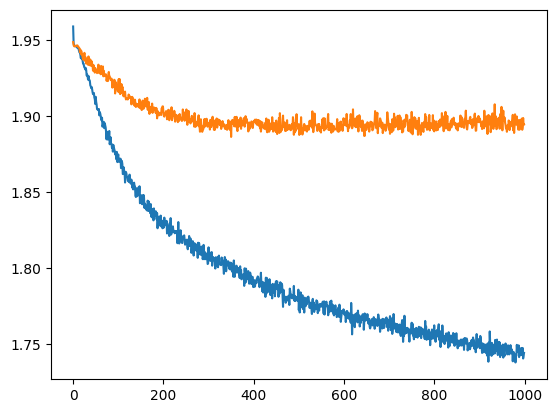

In [ ]:
plt.plot(train_loss)
plt.plot(test_loss)

In [ ]:
test=[]
train=[]
for i in range(len(train_acc)):
    train.append(train_acc[i].to('cpu'))
    test.append(test_acc[i].to('cpu'))
print(test)
print(train)

[tensor(0.1413), tensor(0.1425), tensor(0.1462), tensor(0.1456), tensor(0.1500), tensor(0.1500), tensor(0.1500), tensor(0.1500), tensor(0.1500), tensor(0.1341), tensor(0.1496), tensor(0.1534), tensor(0.1488), tensor(0.1540), tensor(0.1619), tensor(0.1653), tensor(0.1560), tensor(0.1569), tensor(0.1639), tensor(0.1528), tensor(0.1504), tensor(0.1780), tensor(0.1740), tensor(0.1607), tensor(0.1702), tensor(0.1633), tensor(0.1665), tensor(0.1633), tensor(0.1696), tensor(0.1736), tensor(0.1720), tensor(0.1726), tensor(0.1778), tensor(0.1712), tensor(0.1659), tensor(0.1774), tensor(0.1730), tensor(0.1796), tensor(0.1639), tensor(0.1683), tensor(0.1752), tensor(0.1746), tensor(0.1812), tensor(0.1810), tensor(0.1812), tensor(0.1708), tensor(0.1774), tensor(0.1798), tensor(0.1833), tensor(0.1812), tensor(0.1847), tensor(0.1800), tensor(0.1756), tensor(0.1808), tensor(0.1810), tensor(0.1786), tensor(0.1677), tensor(0.1829), tensor(0.1738), tensor(0.1722), tensor(0.1784), tensor(0.1867), tensor(

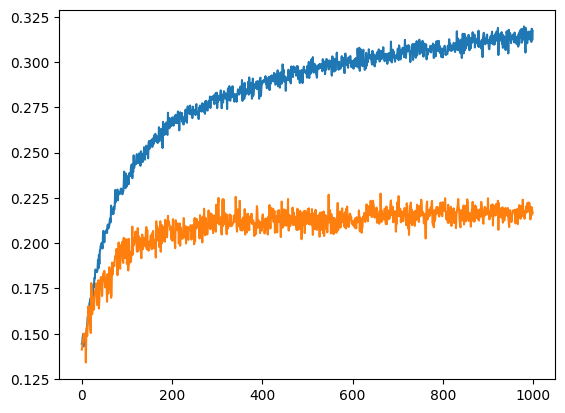

In [ ]:
plt.plot(train)
plt.plot(test)